In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import os

from torch.utils.data import random_split
import matplotlib.pyplot as plt
from torch.utils.data.dataloader import DataLoader
import torch.nn.functional as F
import warnings

import torchvision
import time

import tqdm
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor,Normalize
import torchvision.transforms as transforms


# Data Loader

In [2]:
def Data_loader():

  transform = Compose([ToTensor(),
                       transforms.Normalize((0.5,), (0.5,))])

  train_dataset = MNIST('./data/', train=True, download=True, transform=transform)
  test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

  # Define the size of the training and validation sets
  train_size = int(0.8 * len(train_dataset))    # 80% for training
  valid_size = len(train_dataset) - train_size  # 20% for validation

  # Split the dataset
  train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

  train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
  val_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

  print("Train Size: ",len(train_loader.dataset))
  print("Valid Size: ",len(valid_dataset))
  print("Test Size: ",len(test_dataset))

  return train_loader, val_loader, test_loader

# Convolutional Networks

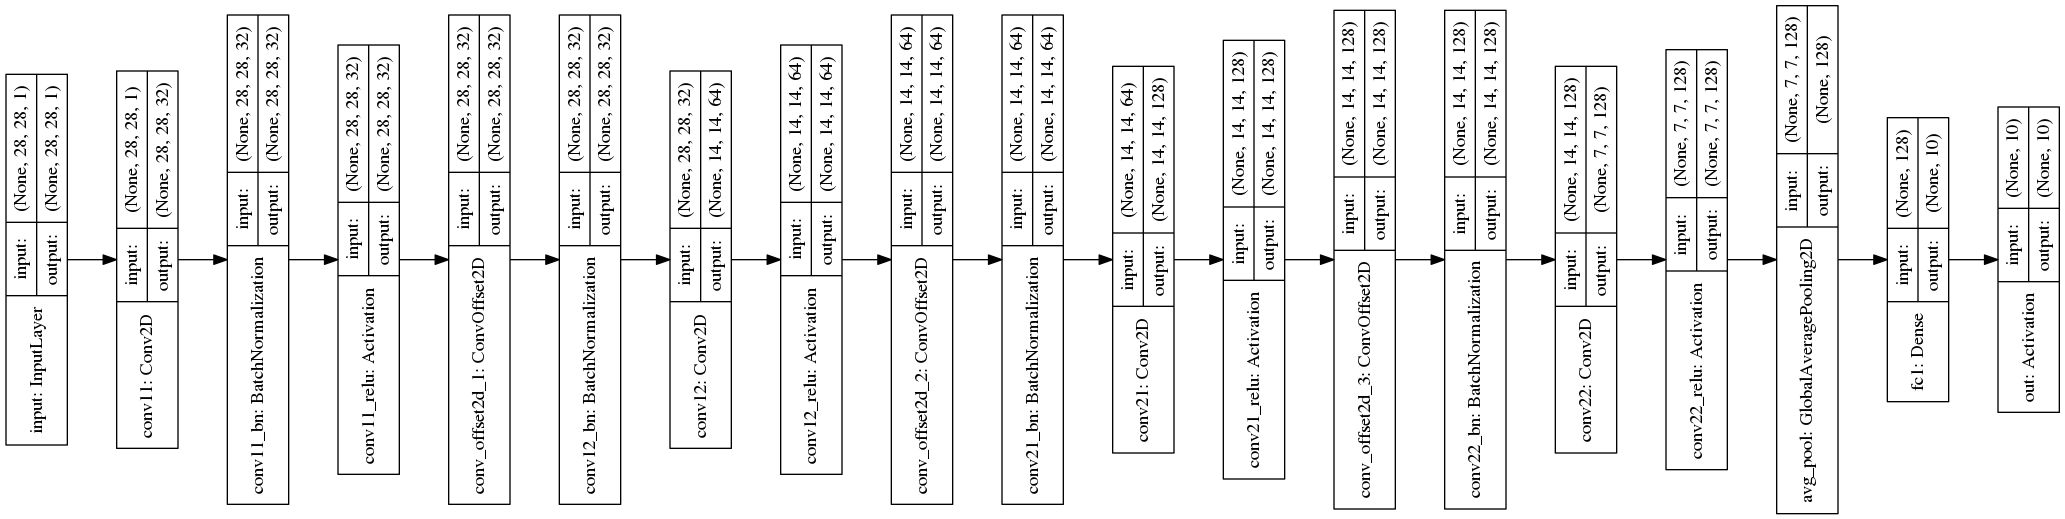

## Model

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()


        self.conv_1 = nn.Conv2d(1, 32, 3, padding=1)
        self.BN_1 = nn.BatchNorm2d(32)
        self.relu_1 = nn.ReLU()

        self.conv_2 = nn.Conv2d(32, 64, 3, padding=1, stride=2)
        self.BN_2 = nn.BatchNorm2d(64)
        self.relu_2 = nn.ReLU()


        self.conv_3 = nn.Conv2d(64, 128, 3, padding= 1)
        self.BN_3 = nn.BatchNorm2d(128)
        self.relu_3 = nn.ReLU()


        self.conv_4 = nn.Conv2d(128, 128, 3, padding=1, stride=2)
        self.BN_4 = nn.BatchNorm2d(128)
        self.relu_4 = nn.ReLU()

        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu_1(x)
        x = self.BN_1(x)


        x = self.conv_2(x)
        x = self.relu_2(x)
        x = self.BN_2(x)

        x = self.conv_3(x)
        x = self.relu_3(x)
        x = self.BN_3(x)

        x = self.conv_4(x)
        x = self.relu_4(x)
        x = self.BN_4(x)

        x=self.pool(x)
        x = x.view(x.size(0), -1)
        x=self.fc(x)
        return x


## Traning

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
model = ConvNet().to(device)

num_epochs = 2

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader, val_loader, test_loader = Data_loader()

# Training and validation loop
train_losses=[]
train_acc=[]
val_losses=[]
val_acc=[]

start=time.time()

for epoch in range(num_epochs):
  # Training phase
  model.train()
  train_loss = 0.0
  val_loss=0.0
  train_correct = 0
  val_correct= 0

  for inputs, labels in tqdm.tqdm(train_loader):

    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    pred=outputs.argmax(dim=1,keepdim=True)
    train_correct+=pred.eq(labels.view_as(pred)).sum().item()

  train_losses.append(train_loss/len(train_loader))
  train_acc.append(train_correct / len(train_loader.dataset))

  model.eval()
  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      val_loss += loss.item()
      pred=outputs.argmax(dim=1,keepdim=True)
      val_correct+=pred.eq(labels.view_as(pred)).sum().item()

  val_losses.append(val_loss / len(val_loader))
  val_acc.append(val_correct / len(val_loader.dataset))

  print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train accuracy:{train_acc[-1]*100:.2f} Validation Loss: {val_losses[-1]:.4f}, Validation accuracy:{val_acc[-1]*100:.2f}")
end=time.time()




Train Size:  48000
Valid Size:  12000
Test Size:  10000


100%|██████████| 375/375 [00:23<00:00, 16.05it/s]


Epoch 1/2, Train Loss: 0.3110, Train accuracy:93.26 Validation Loss: 0.0977, Validation accuracy:97.36


100%|██████████| 375/375 [00:15<00:00, 23.88it/s]


Epoch 2/2, Train Loss: 0.0641, Train accuracy:98.41 Validation Loss: 0.0830, Validation accuracy:97.83


In [6]:
time_conv=end-start
print(f"traning Time: {time_conv:.2f} seconds")

traning Time: 46.26 seconds


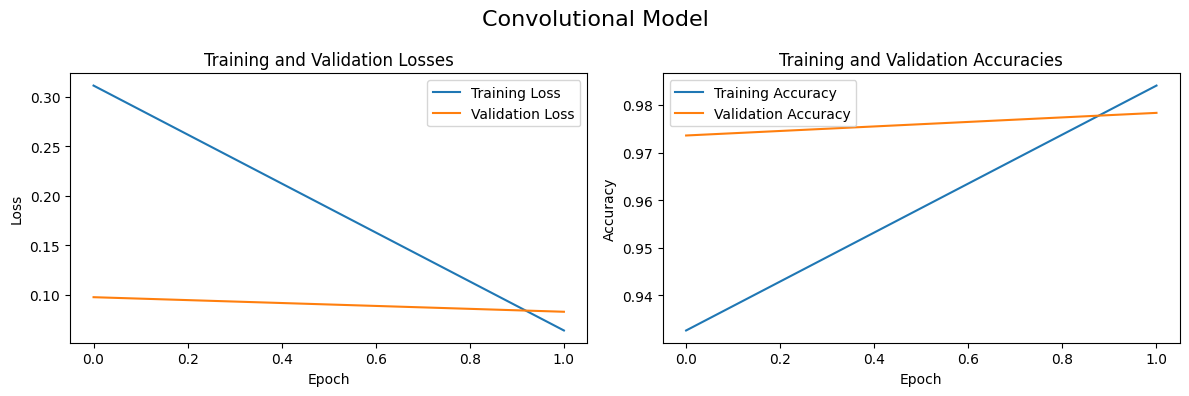

In [7]:
# Plotting losses
plt.figure(figsize=(12, 4))
plt.suptitle('Convolutional Model', fontsize=16)

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracies
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Test

In [8]:
# Test
test_correct = 0
for inputs,labels in test_loader:
  inputs, labels = inputs.to(device), labels.to(device)
  outputs = model(inputs)
  pred=outputs.argmax(dim=1,keepdim=True)
  test_correct += pred.eq(labels.view_as(pred)).sum().item()

test_acc_conv=test_correct/len(test_loader.dataset)*100

print(f"Test accuracy (Conv model) :{test_acc_conv:.2f}")


Test accuracy (Conv model) :98.13


# Deformable Convolutional Networks

## Deformable Convolution

In [21]:
class DeformableConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1):
        super(DeformableConv2D, self).__init__()
        self.kernel_size = kernel_size  # Save kernel size as instance variable

        # Standard convolutional layer
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)

        # Offset and mask generation layers
        self.offset_conv = nn.Conv2d(in_channels, 2 * kernel_size * kernel_size, kernel_size, stride=stride, padding=padding)
        self.mask_conv = nn.Conv2d(in_channels,out_channels , kernel_size, stride=stride, padding=padding)

    def forward(self, x):

        # Generate offset and mask
        offset = self.offset_conv(x)
        mask = 0.2*torch.tanh(self.mask_conv(x))

        # Deformable convolution operation
        output = self.deformable_convolution(x, offset, mask)

        return output

    def deformable_convolution(self, input, offset, mask):
        batch_size, channels, height, width = input.size()

        h_range = torch.arange(0, height, dtype=torch.float32, device=input.device)
        w_range = torch.arange(0, width, dtype=torch.float32, device=input.device)
        warnings.filterwarnings("ignore", category=UserWarning, module="torch.functional")
        h_grid, w_grid = torch.meshgrid(h_range, w_range)

        # Normalize coordinates to [-1, 1]
        h_grid=(2.0*h_grid/(height-1))-1.0
        w_grid=(2.0*w_grid/(width-1))-1.0

        grid = torch.stack((h_grid, w_grid), dim=-1)   # Grid shape: (h, w, 2)
        #offset=self.mj(offset)
        #offset=offset.permute(0, 2, 3, 1)
        #offset=offset.reshape(batch_size,height,width,2,self.kernel_size*self.kernel_size).sum(-1)


        grid = grid.unsqueeze(0).expand(batch_size, -1, -1, -1)  # Grid shape: (batch_size, h, w, 2)
        #print("grid",grid.shape)
        #print("off",offfset.shape)
        #grid = grid + offset  # Apply offsets to grid

        sampled_feature_map = F.grid_sample(input, grid, mode='bilinear', align_corners=False)


        sampled_feature_map=self.conv(sampled_feature_map)

        # Apply mask
        output = sampled_feature_map*mask

        return output




## Model

In [22]:
class DEConvNet(nn.Module):
    def __init__(self):
        super(DEConvNet, self).__init__()


        self.conv_1 = DeformableConv2D(1, 32, 3, padding=1)
        self.BN_1 = nn.BatchNorm2d(32)
        self.relu_1 = nn.ReLU()

        self.conv_2 = DeformableConv2D(32, 64, 3, padding=1, stride=2)
        self.BN_2 = nn.BatchNorm2d(64)
        self.relu_2 = nn.ReLU()


        self.conv_3 = DeformableConv2D(64, 128, 3, padding= 1)
        self.BN_3 = nn.BatchNorm2d(128)
        self.relu_3 = nn.ReLU()


        self.conv_4 = DeformableConv2D(128, 128, 3, padding=1, stride=2)
        self.BN_4 = nn.BatchNorm2d(128)
        self.relu_4 = nn.ReLU()

        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu_1(x)
        x = self.BN_1(x)


        x = self.conv_2(x)
        x = self.relu_2(x)
        x = self.BN_2(x)

        x = self.conv_3(x)
        x = self.relu_3(x)
        x = self.BN_3(x)

        x = self.conv_4(x)
        x = self.relu_4(x)
        x = self.BN_4(x)

        x=self.pool(x)
        x = x.view(x.size(0), -1)
        x=self.fc(x)

        return x


## Training

In [23]:
model = DEConvNet().to(device)

num_epochs = 2

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader, val_loader, test_loader = Data_loader()

# Training and validation loop
train_losses_deconv=[]
train_acc_deconv=[]
val_losses_deconv=[]
val_acc_deconv=[]

start_deconv=time.time()

for epoch in range(num_epochs):
  # Training phase
  model.train()
  train_loss = 0.0
  val_loss=0.0
  train_correct = 0
  val_correct= 0

  for inputs, labels in tqdm.tqdm(train_loader):

    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    pred=outputs.argmax(dim=1,keepdim=True)
    train_correct+=pred.eq(labels.view_as(pred)).sum().item()

  train_losses_deconv.append(train_loss/len(train_loader))
  train_acc_deconv.append(train_correct / len(train_loader.dataset))

  model.eval()
  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      val_loss += loss.item()
      pred=outputs.argmax(dim=1,keepdim=True)
      val_correct+=pred.eq(labels.view_as(pred)).sum().item()

  val_losses_deconv.append(val_loss / len(val_loader))
  val_acc_deconv.append(val_correct / len(val_loader.dataset))

  print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train accuracy:{train_acc[-1]*100:.2f} Validation Loss: {val_losses[-1]:.4f}, Validation accuracy:{val_acc[-1]*100:.2f}")
end_deconv=time.time()




Train Size:  48000
Valid Size:  12000
Test Size:  10000


100%|██████████| 375/375 [00:18<00:00, 19.94it/s]


Epoch 1/2, Train Loss: 0.0641, Train accuracy:98.41 Validation Loss: 0.0830, Validation accuracy:97.83


100%|██████████| 375/375 [00:19<00:00, 19.05it/s]


Epoch 2/2, Train Loss: 0.0641, Train accuracy:98.41 Validation Loss: 0.0830, Validation accuracy:97.83


In [24]:
time_deconv=end_deconv-start_deconv
print(f"traning Time (DEConv): {time_deconv:.2f} seconds")

traning Time (DEConv): 48.30 seconds


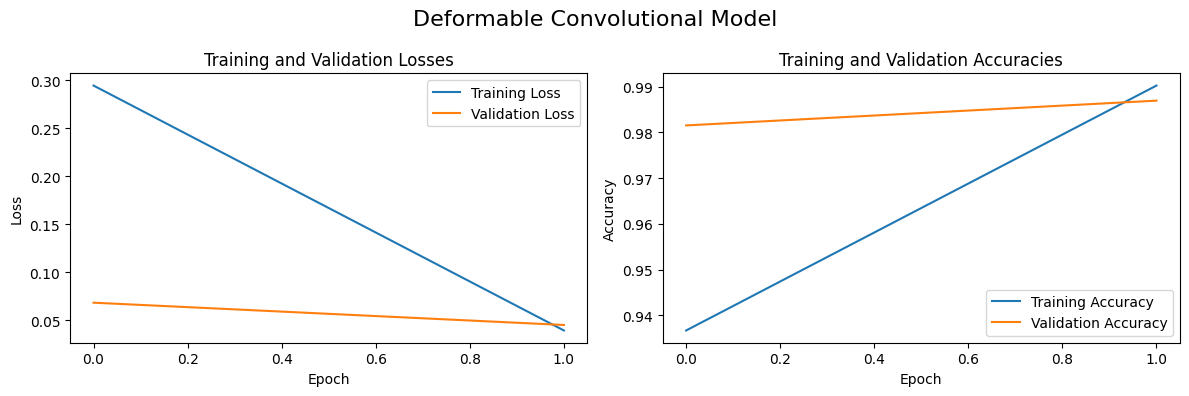

In [25]:
# Plotting losses
plt.figure(figsize=(12, 4))
plt.suptitle('Deformable Convolutional Model', fontsize=16)
plt.subplot(1, 2, 1)
plt.plot(train_losses_deconv, label='Training Loss')
plt.plot(val_losses_deconv, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracies
plt.subplot(1, 2, 2)
plt.plot(train_acc_deconv, label='Training Accuracy')
plt.plot(val_acc_deconv, label='Validation Accuracy')
plt.title('Training and Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Test

In [26]:
# Test
test_correct_deconv = 0
for inputs,labels in test_loader:
  inputs, labels = inputs.to(device), labels.to(device)
  outputs = model(inputs)
  pred=outputs.argmax(dim=1,keepdim=True)
  test_correct_deconv += pred.eq(labels.view_as(pred)).sum().item()

test_acc_deconv=test_correct_deconv/len(test_loader.dataset)*100

print(f"Test accuracy (DEConv Model) :{test_acc_deconv:.2f}")


Test accuracy (DEConv Model) :98.80


# Comparison of two models

## Training Time

In [27]:
print(f"traning Time (ConV): {time_conv:.2f} seconds")
print(f"traning Time (DEConv): {time_deconv:.2f} seconds")

traning Time (ConV): 46.26 seconds
traning Time (DEConv): 48.30 seconds


## Traning and Validation

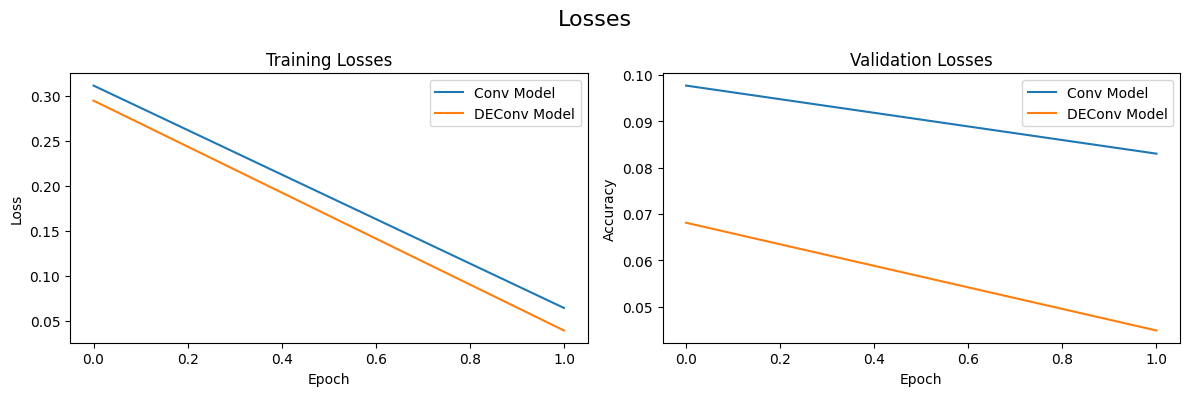

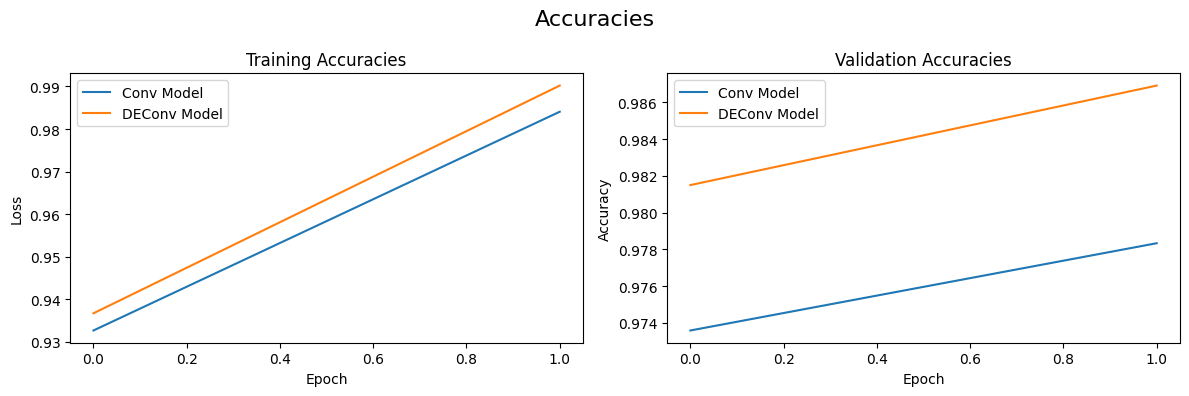

In [28]:
# Plotting losses
plt.figure(figsize=(12, 4))
plt.suptitle('Losses', fontsize=16)
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Conv Model')
plt.plot(train_losses_deconv, label='DEConv Model')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_losses, label='Conv Model')
plt.plot(val_losses_deconv, label='DEConv Model')
plt.title('Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Plotting accuracies
plt.figure(figsize=(12, 4))
plt.suptitle('Accuracies', fontsize=16)
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Conv Model')
plt.plot(train_acc_deconv, label='DEConv Model')
plt.title('Training Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_acc, label='Conv Model')
plt.plot(val_acc_deconv, label='DEConv Model')
plt.title('Validation Accuracies')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



## Test accuracy

In [29]:
print(f"Test accuracy (Conv model) :{test_acc_conv:.2f}")
print(f"Test accuracy (DEConv Model) :{test_acc_deconv:.2f}")


Test accuracy (Conv model) :98.13
Test accuracy (DEConv Model) :98.80


### (a) Difference between Regular Convolutional Networks and Deformable Convolution Networks in terms of Sampling Grid:

Deformable Convolution Networks utilize a more flexible sampling grid to better adapt to geometric changes in images. In regular convolution, the sampling grid is fixed and always centered on a specific point in the image. However, in Deformable Convolution, this grid is allowed to interact with different points in the image, providing adaptability to various geometric changes.

### (b) How Deformable Convolution Networks Introduce Flexibility in Geometric Transformations:

Deformable Convolution Networks introduce flexibility in geometric transformations by incorporating an additional layer into the convolutional architecture known as "Deformable Convolution Layer" or "Convolution Deformable." This layer, using a flexible sampling grid, allows the model to better align with various geometric changes in the image, providing improved compatibility with different transformations.

### (c) Why Regular Convolutional Networks Encounter Serious Issues with Highly Spatially Variant Images:

Regular Convolutional Networks may face serious issues when dealing with images that have significant spatial changes or rotations. These issues include the loss of important information in geometric transformations, difficulties in recognizing objects in different positions, and the loss of spatial relationship information between image components.

### (d) How Offsets in Deformable Convolution are Computed:

Offsets in Deformable Convolution are calculated using a specific layer called the "Deformable Convolution Layer." This layer employs a spatial predictor for each pixel to provide a flexible sampling grid to the model. These flexible grid details determine the displacement (offset) concerning the regular centered position for each point in the image. These offset details enable the model to adapt to various geometric changes in the image.
